In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
import scipy
import time
import collections
import itertools
import librosa
import pickle

# Extract Features from Wave Files

In [2]:
pa_t_h = '/home/zaibachkhoa/Documents/Music-Genre-Classification-From-Audio-Files/Music_Instrument_Classification/dataset/'

#directory to training data and json file
train_dir=f'{pa_t_h}train/nsynth-train/audio/'
assert os.path.isdir(train_dir)
#directory to validing data and json file
valid_dir=f'{pa_t_h}valid/nsynth-valid/audio/'
assert os.path.isdir(valid_dir)
#directory to testing data and json file
test_dir=f'{pa_t_h}test/nsynth-test/audio/'
assert os.path.isdir(test_dir)

- Number of Zero Crossings
- max mean mfcc
- centroid mean
- centroid std
- centroid skewness
- max mean contrast
- rolloff mean
- rolloff std
- rolloff skewness
- zero crossing rate mean
- zero crossing rate std
- zero crossing rate skewness

In [3]:
#read the raw json files as given in the training set
df_train_raw = pd.read_json(path_or_buf=f'{pa_t_h}train/nsynth-train/examples.json', orient='index')

In [4]:
#Get a count of instruments in ascending order
n_class_train= df_train_raw['instrument_family'].value_counts(ascending=True)
n_class_train

9      5501
2      8773
10    10208
1     12675
7     13911
8     19474
3     32690
5     34201
6     34477
4     51821
0     65474
Name: instrument_family, dtype: int64

In [5]:
#Sample n files
df_train_sample=df_train_raw.groupby('instrument_family', as_index=False, #group by instrument family
                               group_keys=False).apply(lambda df: df.sample(5000)) #number of samples
#drop the synth_lead from the training dataset
df_train_sample= df_train_sample[df_train_sample['instrument_family']!=9]

In [6]:
df_train_sample.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_110-108-075,150905,16000,108,2,bass,bass_synthetic_110,bass_synthetic_110-108-075,"[bright, distortion, long_release, multiphonic...",synthetic,75,0,858,"[1, 0, 1, 0, 1, 1, 0, 0, 0, 1]"
bass_synthetic_109-065-025,284141,16000,65,2,bass,bass_synthetic_109,bass_synthetic_109-065-025,"[distortion, fast_decay, percussive]",synthetic,25,0,848,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 0]"
bass_synthetic_055-107-050,192666,16000,107,2,bass,bass_synthetic_055,bass_synthetic_055-107-050,"[bright, distortion]",synthetic,50,0,578,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_084-012-050,97778,16000,12,2,bass,bass_synthetic_084,bass_synthetic_084-012-050,"[bright, distortion, nonlinear_env]",synthetic,50,0,726,"[1, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
bass_synthetic_000-039-100,127615,16000,39,2,bass,bass_synthetic_000,bass_synthetic_000-039-100,[],synthetic,100,0,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


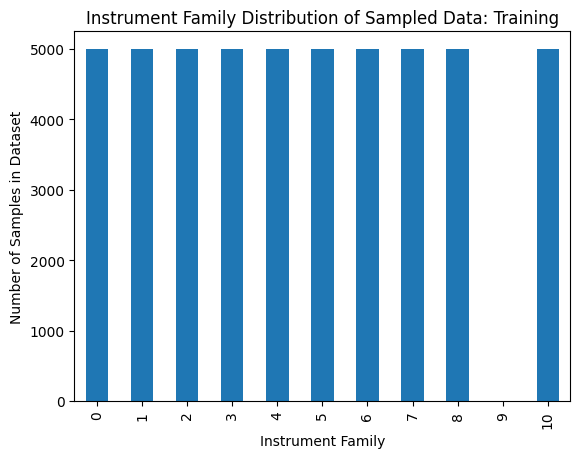

In [7]:
#Display instrument distrution
df_train_sample['instrument_family'].value_counts().reindex(np.arange(0,len(n_class_train), 1)).plot(kind='bar')
plt.title("Instrument Family Distribution of Sampled Data: Training")
plt.xlabel('Instrument Family')
plt.ylabel('Number of Samples in Dataset')
plt.show()

In [8]:
#save the train file index as list
filenames_train = df_train_sample.index.tolist()

In [9]:
#save the list to a pickle file
with open('DataWrangling/filenames_train.pickle', 'wb') as f:
    pickle.dump(filenames_train, f)

In [10]:
#extract the filenames from the validation dataset
df_valid = pd.read_json(path_or_buf=f'{pa_t_h}valid/nsynth-valid/examples.json', orient='index')

#save the train file index as list
filenames_valid = df_valid.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_valid.pickle', 'wb') as f:
    pickle.dump(filenames_valid, f)

In [11]:
#extract the filenames from the testing dataset
df_test = pd.read_json(path_or_buf=f'{pa_t_h}test/nsynth-test/examples.json', orient='index')

#save the train file index as list
filenames_test = df_test.index.tolist()

#save the list to a pickle file
with open('DataWrangling/filenames_test.pickle', 'wb') as f:
    pickle.dump(filenames_test, f)

In [12]:
def feature_extract(file):
    """
    Define function that takes in a file an returns features in an array
    """
    
    #get wave representation
    y, sr = librosa.load(file)
        
    #determine if instruemnt is harmonic or percussive by comparing means
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    if np.mean(y_harmonic)>np.mean(y_percussive):
        harmonic=1
    else:
        harmonic=0
        
    #Mel-frequency cepstral coefficients (MFCCs)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    #temporal averaging
    mfcc=np.mean(mfcc,axis=1)
    
    #get the mel-scaled spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)  
    #temporally average spectrogram
    spectrogram = np.mean(spectrogram, axis = 1)
    
    #compute chroma energy
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    #temporally average chroma
    chroma = np.mean(chroma, axis = 1)
    
    #compute spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast = np.mean(contrast, axis= 1)
    
    return [harmonic, mfcc, spectrogram, chroma, contrast]

In [13]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'synth_lead', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

The function above can take a lot of time for large datasets. It is advisisable to start out on small samples to get an estimate of running time.

## Testing Set

In [14]:
#create dictionary to store all test features
dict_test = {}
#loop over every file in the list
for file in filenames_test:
    #extract the features
    features = feature_extract(test_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_test[file] = features
    

/home/zaibachkhoa/Documents/Music-Genre-Classification-From-Audio-Files/NSynth/venv/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [15]:
#convert dict to dataframe
features_test = pd.DataFrame.from_dict(dict_test, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_test.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_068-049-025,1,"[-522.8658, 46.664146, 34.379803, 24.787596, 1...","[0.010030986, 0.026242847, 0.043270785, 0.0930...","[0.14567767, 0.8257, 0.07661895, 0.034161784, ...","[35.9809870471048, 29.099204988108127, 27.8387..."
keyboard_electronic_001-021-127,0,"[-444.644, 193.89053, 27.298916, -3.6895258, 6...","[0.055242054, 0.1996687, 11.731721, 20.330856,...","[0.08902063, 0.10597091, 0.077824585, 0.392217...","[19.948747677778954, 19.841752110964215, 18.75..."
guitar_acoustic_010-066-100,0,"[-439.3734, 59.546825, 2.8950794, -12.039842, ...","[0.0014635249, 0.002633689, 0.0022025618, 0.00...","[0.10209415, 0.11988667, 0.064387664, 0.072573...","[12.372899640049098, 34.622524570743764, 35.31..."
reed_acoustic_037-068-127,1,"[-372.98746, 68.7968, -39.474766, -22.089418, ...","[0.00014575849, 0.00046337693, 0.00040781283, ...","[0.05025812, 0.038772635, 0.023343502, 0.36616...","[19.619576972284502, 25.605313528080007, 30.76..."
flute_acoustic_002-077-100,1,"[-364.77966, 12.566915, -42.826508, 19.884623,...","[4.9268067e-05, 0.00012820766, 0.00046132287, ...","[0.07728491, 0.08046897, 0.073985286, 0.037789...","[20.515468753784337, 10.440229829452198, 40.26..."


In [16]:
#extract mfccs
mfcc_test = pd.DataFrame(features_test.mfcc.values.tolist(),index=features_test.index)
mfcc_test = mfcc_test.add_prefix('mfcc_')

#extract spectro
spectro_test = pd.DataFrame(features_test.spectro.values.tolist(),index=features_test.index)
spectro_test = spectro_test.add_prefix('spectro_')


#extract chroma
chroma_test = pd.DataFrame(features_test.chroma.values.tolist(),index=features_test.index)
chroma_test = chroma_test.add_prefix('chroma_')


#extract contrast
contrast_test = pd.DataFrame(features_test.contrast.values.tolist(),index=features_test.index)
contrast_test = chroma_test.add_prefix('contrast_')

#drop the old columns
features_test = features_test.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_test=pd.concat([features_test, mfcc_test, spectro_test, chroma_test, contrast_test],
                           axis=1, join='inner')
df_features_test.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_068-049-025,1,-522.865784,46.664146,34.379803,24.787596,17.420424,10.198802,4.609534,1.380600,-1.023339,...,0.076619,0.034162,0.035634,0.025365,0.019434,0.039115,0.092514,0.086638,0.061319,0.091409
keyboard_electronic_001-021-127,0,-444.644012,193.890533,27.298916,-3.689526,6.295265,8.093065,10.283859,6.089182,2.495068,...,0.077825,0.392218,0.563529,0.143236,0.164834,0.211634,0.353580,0.422365,0.019230,0.009007
guitar_acoustic_010-066-100,0,-439.373413,59.546825,2.895079,-12.039842,-12.553241,-11.451954,-12.535439,-20.456728,-19.256971,...,0.064388,0.072573,0.091863,0.090990,0.840737,0.093613,0.048391,0.030883,0.015003,0.009667
reed_acoustic_037-068-127,1,-372.987457,68.796799,-39.474766,-22.089418,-50.149685,-16.565741,-29.849133,-16.627388,-17.712204,...,0.023344,0.366166,0.036109,0.006731,0.023056,0.020713,0.885966,0.061736,0.016221,0.002263
flute_acoustic_002-077-100,1,-364.779663,12.566915,-42.826508,19.884623,-29.598238,-21.321136,-18.308319,-9.495083,7.672036,...,0.073985,0.037789,0.052419,0.910790,0.022027,0.030132,0.009579,0.028886,0.048302,0.016970


In [17]:
targets_test = []
for name in df_features_test.index.tolist():
    targets_test.append(instrument_code(name))

df_features_test['targets'] = targets_test

In [18]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_test.pickle', 'wb') as f:
    pickle.dump(df_features_test, f)

In [19]:
df_features_test.shape

(4096, 167)

## Traning Set

In [20]:
start_train = time.time()

#create dictionary to store all test features
dict_train = {}
#loop over every file in the list
for file in filenames_train:
    #extract the features
    features = feature_extract(train_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_train[file] = features

end_train=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_train), end_train - start_train))

/home/zaibachkhoa/Documents/Music-Genre-Classification-From-Audio-Files/NSynth/venv/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Time to extract 50000 files is 10346.363898992538 seconds


In [21]:
#convert dict to dataframe
features_train = pd.DataFrame.from_dict(dict_train, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_train.head()

,harmonic,mfcc,spectro,chroma,contrast
bass_synthetic_110-108-075,0,"[-333.51913, 2.9338238, -36.707424, 30.884054,...","[1.9198668, 0.15206142, 0.07635687, 0.05584915...","[0.6064344, 0.47653022, 0.18327537, 0.22823073...","[25.04680450775249, 12.713731357751648, 15.646..."
bass_synthetic_109-065-025,1,"[-621.17615, 4.1773834, 0.45275316, 1.2826012,...","[0.008064684, 0.015689898, 0.050767183, 0.0973...","[0.3503323, 0.3612438, 0.32317135, 0.2829508, ...","[9.460833149191584, 9.725926005845569, 9.80737..."
bass_synthetic_055-107-050,0,"[-521.55194, -11.754347, -3.858067, 20.784029,...","[9.489023e-05, 0.0004097324, 4.784637e-05, 1.9...","[0.03286215, 0.033041496, 0.0304317, 0.0569456...","[25.572044890086428, 22.218182704602988, 21.98..."
bass_synthetic_084-012-050,0,"[-406.29327, 69.002266, 44.04343, 29.855034, 2...","[1084.6646, 760.4358, 70.527855, 71.2134, 20.9...","[0.8111366, 0.3132565, 0.13380373, 0.014751859...","[26.287482967008398, 13.185585645649985, 14.70..."
bass_synthetic_000-039-100,1,"[-436.96188, 42.32112, 27.7623, 19.08215, 14.1...","[0.34908214, 23.109592, 748.9538, 407.1095, 1....","[0.0671533, 0.06518911, 0.10204182, 0.8448929,...","[30.884505042321933, 26.252739750061558, 29.92..."


In [22]:
#extract mfccs
mfcc_train = pd.DataFrame(features_train.mfcc.values.tolist(),
                          index=features_train.index)
mfcc_train = mfcc_train.add_prefix('mfcc_')

#extract spectro
spectro_train = pd.DataFrame(features_train.spectro.values.tolist(),
                             index=features_train.index)
spectro_train = spectro_train.add_prefix('spectro_')


#extract chroma
chroma_train = pd.DataFrame(features_train.chroma.values.tolist(),
                            index=features_train.index)
chroma_train = chroma_train.add_prefix('chroma_')


#extract contrast
contrast_train = pd.DataFrame(features_train.contrast.values.tolist(),
                              index=features_train.index)
contrast_train = chroma_train.add_prefix('contrast_')

#drop the old columns
features_train = features_train.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_train=pd.concat([features_train, mfcc_train, spectro_train, chroma_train, contrast_train],
                           axis=1, join='inner')
df_features_train.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
bass_synthetic_110-108-075,0,-333.519135,2.933824,-36.707424,30.884054,-28.997353,20.344494,-0.293386,15.807535,8.547583,...,0.183275,0.228231,0.177406,0.149816,0.132034,0.343041,0.227495,0.122923,0.122777,0.115667
bass_synthetic_109-065-025,1,-621.176147,4.177383,0.452753,1.282601,-0.882964,-0.076867,-0.789888,0.027981,-0.666479,...,0.323171,0.282951,0.280331,0.264468,0.233711,0.216045,0.228844,0.249875,0.239203,0.229569
bass_synthetic_055-107-050,0,-521.551941,-11.754347,-3.858067,20.784029,-14.809525,7.784602,12.068498,-12.896134,6.200492,...,0.030432,0.056946,0.108375,0.116438,0.113959,0.053517,0.002848,0.001086,0.001086,0.819254
bass_synthetic_084-012-050,0,-406.293274,69.002266,44.043430,29.855034,27.764938,26.789261,23.259752,19.822796,17.532284,...,0.133804,0.014752,0.061106,0.008868,0.042719,0.283062,0.002687,0.002474,0.010247,0.046735
bass_synthetic_000-039-100,1,-436.961884,42.321121,27.762300,19.082150,14.107945,11.303624,9.493841,8.715858,7.970356,...,0.102042,0.844893,0.302405,0.065063,0.029362,0.038805,0.053596,0.005832,0.038143,0.039965


In [23]:
targets_train = []
for name in df_features_train.index.tolist():
    targets_train.append(instrument_code(name))


In [24]:
df_features_train['targets'] = targets_train

In [25]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_train.pickle', 'wb') as f:
    pickle.dump(df_features_train, f)

In [26]:
df_features_train.shape

(50000, 167)

## Validation Set

In [27]:
start_valid = time.time()

#create dictionary to store all test features
dict_valid = {}
#loop over every file in the list
for file in filenames_valid:
    #extract the features
    features = feature_extract(valid_dir+ file + '.wav') #specify directory and .wav
    #add dictionary entry
    dict_valid[file] = features

end_valid=time.time()
print('Time to extract {} files is {} seconds'.format(len(filenames_valid), end_valid - start_valid))

/home/zaibachkhoa/Documents/Music-Genre-Classification-From-Audio-Files/NSynth/venv/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Time to extract 12678 files is 2516.300457715988 seconds


In [28]:
#convert dict to dataframe
features_valid = pd.DataFrame.from_dict(dict_valid, orient='index',
                                       columns=['harmonic', 'mfcc', 'spectro', 'chroma', 'contrast'])

features_valid.head()

,harmonic,mfcc,spectro,chroma,contrast
keyboard_acoustic_004-060-025,1,"[-475.22824, 57.87193, 45.420784, 33.626812, 2...","[1.1800036, 2.7473865, 0.977456, 2.6299975, 2....","[0.7166769, 0.118479714, 0.11610127, 0.0989934...","[20.836237766810655, 29.13227883104324, 28.207..."
bass_synthetic_033-050-100,1,"[-423.16907, 69.13416, 45.368763, 22.640657, 8...","[2.3157594, 0.028705625, 0.035071652, 0.127537...","[0.09737051, 0.10904769, 0.7844097, 0.29963982...","[30.731975455942965, 29.64256788864652, 32.866..."
bass_synthetic_009-052-050,0,"[-148.79364, 52.619366, -49.405605, 72.2587, -...","[0.8193135, 0.022450754, 0.01285848, 0.0213028...","[0.0009445405, 0.0, 0.0019584536, 0.05426022, ...","[32.36755744716005, 30.655247673855214, 34.711..."
keyboard_electronic_003-064-127,0,"[-500.11624, 47.007904, 13.829725, 8.717097, 3...","[0.00067951495, 0.003012088, 0.01650007, 0.015...","[0.0, 0.0, 0.0009528077, 0.07996129, 0.7755068...","[17.15232469413929, 29.86701346313538, 30.1705..."
bass_synthetic_034-030-050,1,"[-411.50037, 67.41016, 39.17504, 55.957657, 24...","[0.96107316, 4.6424894, 84.4477, 434.8653, 83....","[0.046832282, 0.39849162, 0.027044924, 0.01652...","[28.73930170952461, 20.733269387360153, 20.379..."


In [29]:
#extract mfccs
mfcc_valid = pd.DataFrame(features_valid.mfcc.values.tolist(),
                          index=features_valid.index)
mfcc_valid = mfcc_valid.add_prefix('mfcc_')

#extract spectro
spectro_valid = pd.DataFrame(features_valid.spectro.values.tolist(),
                             index=features_valid.index)
spectro_valid = spectro_valid.add_prefix('spectro_')


#extract chroma
chroma_valid = pd.DataFrame(features_valid.chroma.values.tolist(),
                            index=features_valid.index)
chroma_valid = chroma_valid.add_prefix('chroma_')


#extract contrast
contrast_valid = pd.DataFrame(features_valid.contrast.values.tolist(),
                              index=features_valid.index)
contrast_valid = chroma_valid.add_prefix('contrast_')

#drop the old columns
features_valid = features_valid.drop(labels=['mfcc', 'spectro', 'chroma', 'contrast'], axis=1)

#concatenate
df_features_valid=pd.concat([features_valid, mfcc_valid, spectro_valid, chroma_valid, contrast_valid],
                           axis=1, join='inner')
df_features_valid.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,contrast_chroma_2,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11
keyboard_acoustic_004-060-025,1,-475.228241,57.871929,45.420784,33.626812,23.861399,16.505726,11.225738,6.615819,2.428365,...,0.116101,0.098993,0.212848,0.251691,0.214841,0.128957,0.139373,0.083054,0.056506,0.099800
bass_synthetic_033-050-100,1,-423.169067,69.134163,45.368763,22.640657,8.431943,1.126918,-2.505024,-3.276565,-2.163704,...,0.784410,0.299640,0.032777,0.035559,0.048770,0.008362,0.048000,0.265016,0.048340,0.031035
bass_synthetic_009-052-050,0,-148.793640,52.619366,-49.405605,72.258698,-47.938255,37.455559,-38.765911,19.981674,-24.018890,...,0.001958,0.054260,0.889927,0.049914,0.000945,0.000945,0.114643,0.000000,0.000000,0.434259
keyboard_electronic_003-064-127,0,-500.116241,47.007904,13.829725,8.717097,3.275882,-1.387257,-5.367675,-7.053995,-8.340772,...,0.000953,0.079961,0.775507,0.115766,0.052649,0.165960,0.116424,0.088785,0.002494,0.048147
bass_synthetic_034-030-050,1,-411.500366,67.410156,39.175041,55.957657,24.589695,26.617323,12.020110,12.310730,6.211543,...,0.027045,0.016523,0.055971,0.282434,0.750461,0.151187,0.031541,0.027086,0.033757,0.028578


In [30]:
targets_valid = []
for name in df_features_valid.index.tolist():
    targets_valid.append(instrument_code(name))

df_features_valid['targets'] = targets_valid

In [31]:
df_features_valid.shape

(12678, 167)

In [32]:
#save the dataframe to a pickle file
with open('DataWrangling/df_features_valid.pickle', 'wb') as f:
    pickle.dump(df_features_valid, f)

# Clean JSON Files

In [33]:
#extract qualities
train_qual = pd.DataFrame(df_train_sample.qualities.values.tolist(), index= df_train_sample.index)


#concatenate
json_train=pd.concat([df_train_sample, train_qual],
                           axis=1, join='inner')

json_train= json_train.drop(labels=['qualities'], axis=1)
json_train.head()

,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,...,0,1,2,3,4,5,6,7,8,9
bass_synthetic_110-108-075,150905,16000,108,2,bass,bass_synthetic_110,bass_synthetic_110-108-075,"[bright, distortion, long_release, multiphonic...",synthetic,75,...,1,0,1,0,1,1,0,0,0,1
bass_synthetic_109-065-025,284141,16000,65,2,bass,bass_synthetic_109,bass_synthetic_109-065-025,"[distortion, fast_decay, percussive]",synthetic,25,...,0,0,1,1,0,0,0,1,0,0
bass_synthetic_055-107-050,192666,16000,107,2,bass,bass_synthetic_055,bass_synthetic_055-107-050,"[bright, distortion]",synthetic,50,...,1,0,1,0,0,0,0,0,0,0
bass_synthetic_084-012-050,97778,16000,12,2,bass,bass_synthetic_084,bass_synthetic_084-012-050,"[bright, distortion, nonlinear_env]",synthetic,50,...,1,0,1,0,0,0,1,0,0,0
bass_synthetic_000-039-100,127615,16000,39,2,bass,bass_synthetic_000,bass_synthetic_000-039-100,[],synthetic,100,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#save the dataframe to a pickle file
with open('DataWrangling/json_train.pickle', 'wb') as f:
    pickle.dump(json_train, f)

In [35]:
#extract qualities
test_qual = pd.DataFrame(df_test.qualities.values.tolist(), index= df_test.index)


#concatenate
json_test=pd.concat([df_test, test_qual],
                           axis=1, join='inner')

json_test= json_test.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_test.pickle', 'wb') as f:
    pickle.dump(json_test, f)

In [36]:
#extract qualities
valid_qual = pd.DataFrame(df_valid.qualities.values.tolist(), index= df_valid.index)


#concatenate
json_valid=pd.concat([df_valid, valid_qual],
                           axis=1, join='inner')

json_valid= json_valid.drop(labels=['qualities'], axis=1)

#save the dataframe to a pickle file
with open('DataWrangling/json_valid.pickle', 'wb') as f:
    pickle.dump(json_valid, f)